**Import standard necessary libraries**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ngsolve
import sympy

**Import classes and functions from this package.**

- `hydrodynamics.py` contains the `Hydrodynamics`-class, which stores all model options, boundary conditions, weak forms etc. This is the most important class in the code.
- `boundary_fitted_coordinates.py` contains functions to construct boundary-fitted coordinates (curvilinear) to the model geometry. These functions are necessary to construct spatially varying parameters like the prescribed density field and the bathymetry.
- `spatial_parameter.py` contains the class `SpatialParameter`, which constructs `ngsolve`-coefficient functions and their gradients corresponding to spatially varying parameters, using boundary-fitted coordinates.
- The `geometry`-subpackage contains two important files: `create_geometry`, which contains functions to create a `netgen` geometry, and some variables to keep track of the names of specific boundaries of the geometries. The other file, `geometries` contains functions to generate specific geometries, like rectangular geometries, exponentially converging geometries, etc. using parametric curves. These can be turned into `netgen`-geometries using the function `parametric_geometry` in `create_geometry`.
- `TruncationBasis.py` contains properties of the vertical and temporal basis functions on which model equations are projected, as well as two predefined bases fitting to the model equations.
- `solve.py` contains functions to solve the model equations.
- `postprocessing.py` contains the `PostProcessing`-class to postprocess the 'raw' solution. When initialising a `PostProcessing`-object, the solution vector of basis coefficients is turned into interpretable velocity fields. After, a large number of plotting functions are available


In [2]:
from hydrodynamics import *
import boundary_fitted_coordinates
from spatial_parameter import SpatialParameter
from geometry.geometries import *
from geometry.create_geometry import parametric_geometry, WALLDOWN, WALLUP, RIVER, SEA, BOUNDARY_DICT
from TruncationBasis import eigbasis_constantAv, unit_harmonic_time_basis
from solve import solve
from postprocessing import *

**Construct the geometry and the mesh**

For this example, we will work with a rectangular estuary that is 20 km long and 3 km wide. To this end, we define the numbers `L` and `B` to be 20 km and 3 km respectively. Afterwards, we create parametric curves for a rectangular estuary using `parametric_rectangle`. Note that we specify the length and width to both be equal to 1. Later, when initialising the `Hydrodynamics`-object, we specify that the x- and y-coordinates are scaled by `L` and `B` respectively.

After, we specify the mesh element size (in scaled coordinates!), as well as the dictionaries `boundary_parameter_partition_dict` and `boundary_maxh_dict`. These dictionaries allow us to specify that along certain parts of the boundary, the elements must be smaller. In `boundary_parameter_partition_dict`, one specifies for each of the four boundaries the endpoints of a partition, starting at 0 and ending at 1. Subsequently, `boundary_maxh_dict` contains the element size for each of the partitions for each boundary. In this example, we specify a uniform mesh size, so `boundary_parameter_partition_dict` contains only 0 and 1 (a trivial 'partition'), and `boundary_maxh_dict` specifies the global element size for each boundary.

The `netgen`-geometry can now be generated using the function `parametric_geometry`, after which the mesh is generated. Note: even if a variable element size is specified, the mesh is to be generated with keyword argument `maxh=maxh_global`.

In [3]:
L = 20e3
B = 3e3

geometrycurves = parametric_rectangle(1, 1)
maxh_global = 0.15

boundary_parameter_partition_dict = {WALLDOWN: [0,1], WALLUP: [0,1], RIVER: [0,1], SEA: [0,1]}  
boundary_maxh_dict = {WALLDOWN: [maxh_global], WALLUP: [maxh_global], RIVER: [maxh_global], SEA: [maxh_global]} 

geometry = parametric_geometry(geometrycurves, boundary_parameter_partition_dict, boundary_maxh_dict)

mesh = ngsolve.Mesh(geometry.GenerateMesh(maxh=maxh_global))

**Setting constant parameters**

Now we specify the constant parameters to be used in the model. First, some numerical parameters:
- `sem_order`: the (polynomial) order of the spectral element basis.
- `M`: the number of vertical components taken into account.
- `imax`: the number of tidal constituents taken into account, *outside* of the residual flow, which is always taken into account. In this example, we use the residual flow as well as the semidiurnal flow.

Subsequently, some constant 'physical' parameters may be defined:
- `advection_epsilon`: an artificial factor that can dampen the non-linear effect of advection for convergence purposes. In this application, we shall not need this, and hence set it to be 1.
- `g`: gravitational acceleration.
- `f`: Coriolis frequency corresponding to the latitude of interest.
- `Av`: vertical eddy viscosity. It is also possible to choose the eddy viscosity to scale linearly with the local depth. This can be done when selecting the model options later. In this case, the constant parameter `Av` is the constant factor by which the local depth is multiplied.
- `rho0`: reference water density.
- `beta`: coefficient of saline contraction.
- `sigma`: (non-angular) semidiurnal tidal frequency.

In [4]:
sem_order = 6
M = 7
imax = 1

advection_epsilon = 1

g = 9.81
f = 1e-4
Av = 0.01
rho0 = 1020
beta = 7.6e-4
sigma = 2 / 89428.32720 

**Setting spatially variable parameters**

There are also some parameters that are variable in (horizontal) space.

- `H`: the bathymetry, chosen to be a Gaussian profile in this example.
- `rho`: the (depth-independent) density field.
- `R`: the reference water level, chosen to be 0 in this exampple.
- `ramp`: an artificial factor controlling the strength of non-linearities; this can be used if (unphysical) boundary layers due to (slightly) incompatible boundary conditions cause large gradients in the non-linearities, making convergence difficult. In this example, this will not be necessary.

The parameters are generated using boundary-fitted coordinates, generated using the same mesh and spectral element order as the model. These boundary-fitted coordinates, `xi` for the along-channel direction and `eta` for the cross-channel direction run from 0 to 1 and -0.5 to 0.5 respectively.

In [5]:
bfc = boundary_fitted_coordinates.generate_bfc(mesh, sem_order, "diffusion", alpha=1)

C = 6 # bathymetric steepness parameter 
Hscale = 10 # bathymetric scale parameter
Hoffset = 2 # bathymetric offset parameter

def make_H(Ho, Hs, steepness): # this is a closure, because if we save this function for later, we don't need to respecify C, Hscale and Hoffset
    def H(xi, eta): 
        return Ho + Hs * sympy.exp(-steepness * eta**2)
    return H
    
def make_rho(ref_dens, saline_contraction):
    def rho(xi, eta): # water density following the hyperbolic tangent profile from Talke et al. (2009)
        Ssea = 30 # salinity at sea
        xi_L = 0.235
        xi_c = 0.5
        S = Ssea / 2 * (1 - sympy.tanh((xi-xi_c)/xi_L))
        return ref_dens * (1 + saline_contraction * S)
    return rho


def make_ramp(slope, offset):
    def ramp(xi, eta):
        return 0.5 * (sympy.tanh((xi-offset) * slope) + 1)
    return ramp


def R(xi, eta):
    return 0 * xi

H_sp = SpatialParameter(make_H(Hoffset, Hscale, C), bfc)
rho_sp = SpatialParameter(make_rho(rho0, beta), bfc)
R_sp = SpatialParameter(R, bfc)
ramp_sp = SpatialParameter(make_ramp(0, 0), bfc)

**Create the `Hydrodynamics`-object**

It is now finally time to bring everything together and define the `Hydrodynamics`-object. First, a dictionary of model options is made using the function `select_model_options`. The available options are as follows:

- `bed_bc`: choice of boundary condition at the river bed. Currently, only the no-slip condition is available, specified by `'no_slip'`.
- `surface_in_sigma`: flag indicating whether the dynamic water surface should be used in the sigma-coordinates of the model. Physically, this should be true, but for now (to limit the non-linearity of the system), only False is supported.
- `veddy_viscosity_assumption`: option to use a constant vertical eddy viscosity or a vertical eddy viscosity that scales linearly with local depth.
- `density`: option to choose a depth-independent or depth-dependent density profile. Currently, only `'depth-independent'` is possible.
- `advection_epsilon`: specify the artificial dampening factor for advection introduced before.
- `advection_influence_matrix`: boolean matrix, in which entry `[i,j]` indicates whether tidal constituent `i` is affected by momentum advection from tidal constituent `j`. In this example (for numerical reasons), the only influence of advection is from the semidiurnal tide onto the residual flow.
- `x_scaling` and `y_scaling`: constant factors by which the geometry defined before is scaled. This has an effect on the form of the equations. 

After specifying the options, the `Hydrodynamics`-object is constructed. Note that we use the pre-specified vertical and temporal bases `unit_harmonic_time_basis` and `eigbasis_constantAv`. Any additional physical parameters are added to the object via the functions `set_..._physical_parameters`.

In [6]:
model_options = select_model_options(bed_bc='no_slip',
                                     surface_in_sigma=False,
                                     veddy_viscosity_assumption='constant', 
                                     density='depth-independent',
                                     advection_epsilon=advection_epsilon,
                                     advection_influence_matrix=np.array([[False, True],
                                                                          [False, False]]),
                                     x_scaling=L,
                                     y_scaling=B)

hydro = Hydrodynamics(mesh, model_options, imax, M, sem_order, unit_harmonic_time_basis, eigbasis_constantAv)
hydro.set_constant_physical_parameters(Av=Av, sigma=sigma, g=g, f=f)
hydro.set_spatial_physical_parameters(H=H_sp, density=rho_sp, R=R_sp, nonlinear_ramp=ramp_sp)

**Set seaward and riverine boundary conditions**

The seaward (tidal water level) and riverine boundary (stationary river discharge) can be set per tidal constituent, and have to be added to the `Hydrodynamics`-object.

In [7]:
tide_amplitude_list = [0, 1] # per constituent
tide_phase_list = [0, 0]
hydro.set_seaward_boundary_condition(tide_amplitude_list, tide_phase_list)

discharge_amplitude_list = [0.1]
discharge_phase_list = [0]
hydro.set_riverine_boundary_condition(discharge_amplitude_list, discharge_phase_list, is_constant=True)

**Solving the model**

We can solve the model equations using the function `solve`. This solves the equations using a Newton-Raphson method with a certain maximum number of iterations and tolerance. It is also possible to use a continuation (homology) method to ease convergence. For this, we refer to the documentation in `solve.py`. 

In [8]:
solve(hydro, max_iterations=5, tolerance=1e-9)

Initiating solution procedure for hydrodynamics-model with 7 vertical components and 2 tidal constituents (including residual).
In total, there are 45 equations. The total number of free degrees of freedom is 83076.

CONTINUATION STEP 0: Epsilon = 1, Av = 0.01.

Setting up full weak form

Newton-Raphson iteration 0
    Weak form construction took 2.4271004000001994 seconds
    Assembly took 30.536155300000246 seconds
    Inversion took 53.301072600001135 seconds
    Evaluating weak form at current Newton iterate took 5.530823200000668 seconds.
    Stopping criterion value is 1.3583910518015556e-08

Newton-Raphson iteration 1
    Weak form construction took 2.9890761000006023 seconds
    Assembly took 31.211106400000062 seconds
    Inversion took 44.85227180000038 seconds
    Evaluating weak form at current Newton iterate took 5.514550199999576 seconds.
    Stopping criterion value is 2.0120150872139402e-20

Newton-Raphson method converged

Solution process complete.


**Postprocessing**

To visualise the results, we construct a `PostProcessing`-object associated to our solved `Hydrodynamics`-object. After, we plot the amplitude of the depth-averaged semidiurnal along-channel velocity from a top-down view, and the residual velocity in the central cross-section. Many more plotting options are available. Do not forget `plt.show()`!

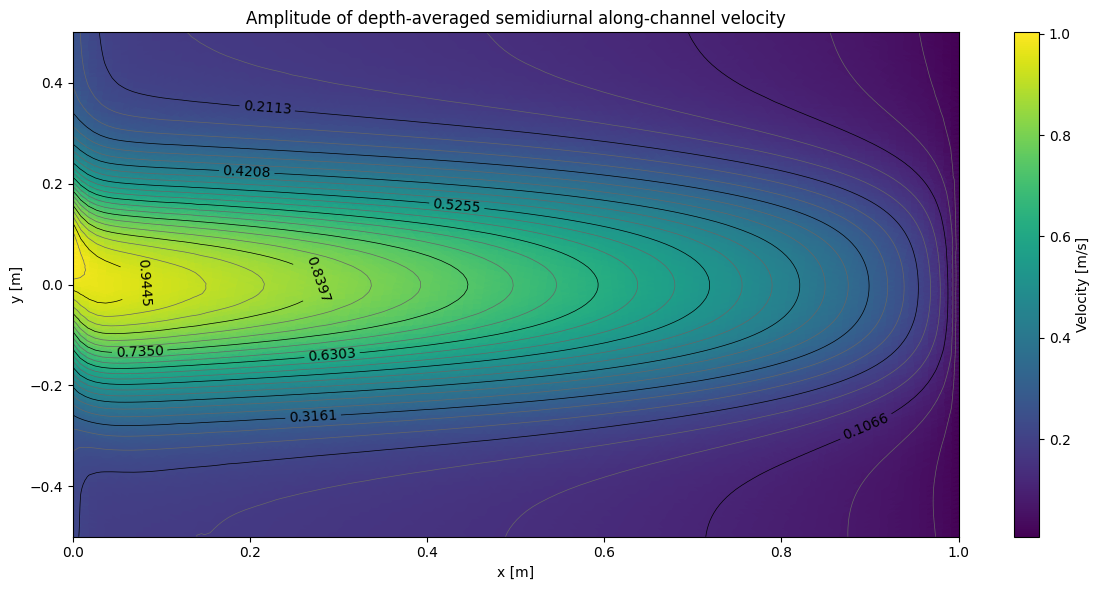

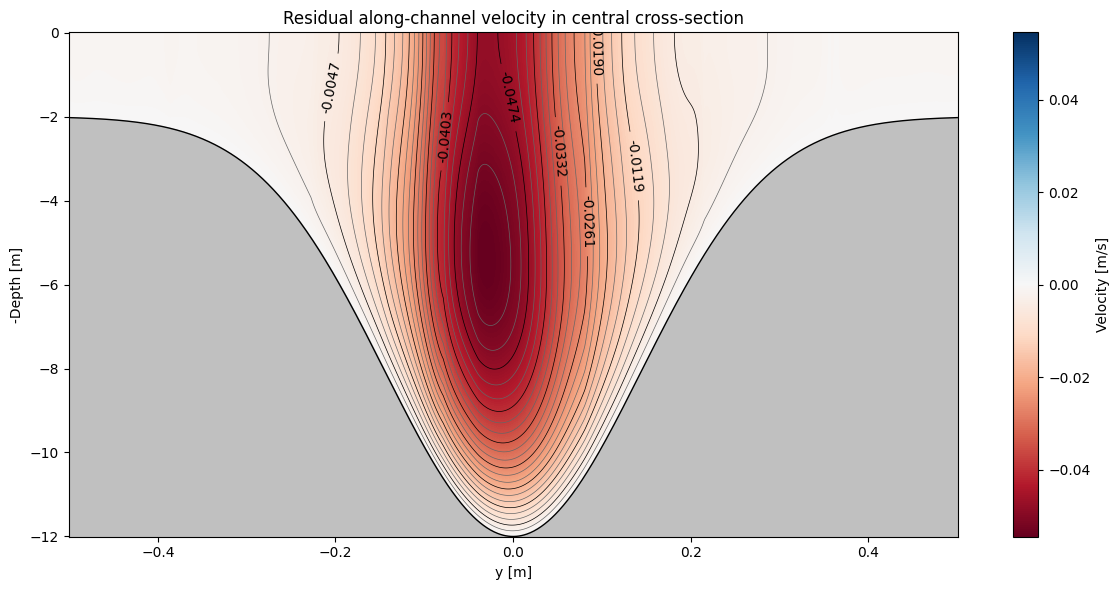

In [10]:
postpro = PostProcessing(hydro)

p1 = np.array([0.5, 0.5])
p2 = np.array([0.5, -0.5])

postpro.plot_colormap(postpro.u_DA_abs(1), refinement_level=4, title='Amplitude of depth-averaged semidiurnal along-channel velocity', clabel='Velocity [m/s]')
postpro.plot_vertical_cross_section(lambda sig: postpro.u(0, sig), 'Residual along-channel velocity in central cross-section', 'Velocity [m/s]', p1, p2, 1000, 1000, center_range=True, cmap='RdBu')

plt.show()